In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
strategyname = 'strategy_270225'
d, info = matlab.loaddata('../mat/'+strategyname+'.mat')

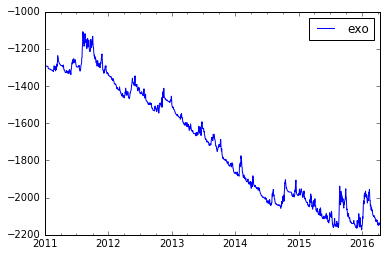

In [4]:
d.plot()


In [5]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

<h1>Simple entry and exit rules based on MA crossing</h1>

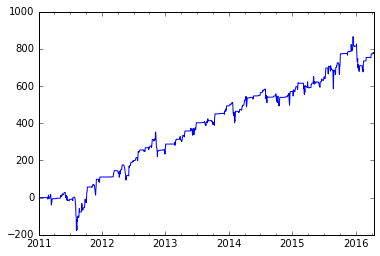

In [6]:
#Defining entry\exit rules
d_slice=d.ix['2010':]
slow_ma = d_slice.exo.rolling(5).mean()
fast_ma = d_slice.exo.rolling(6).mean()

short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) 

direction = -1
pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition)

#X axis, initial equity curve
#Colored blue
x=equity
x.plot()

# Step 1: volatility based sizing for normalizing risk for EXO

In [7]:
# Risk per volatility unit
risk_perunit = 10

#
# Median of EXO changes
#
vola = abs(d_slice.exo.shift(1) - d_slice.exo.shift(2)).rolling(10).median()
volatility_metric = risk_perunit / vola

values_a = []
index_a = []

for i in range(1, len(equity)):
    #
    # on opening of new position, we calculate position size
    #
    if inposition[i] == 1 and inposition[i - 1] == 0:
        current_position_size = volatility_metric[i]

    elif inposition[i] == 1 and inposition[i - 1] == 1:
        current_position_size = current_position_size

    else:
        current_position_size = 0
    values_a.append(current_position_size)
    index_a.append(equity.index[i])

possize_vola_median = pd.Series(values_a, index=[index_a])

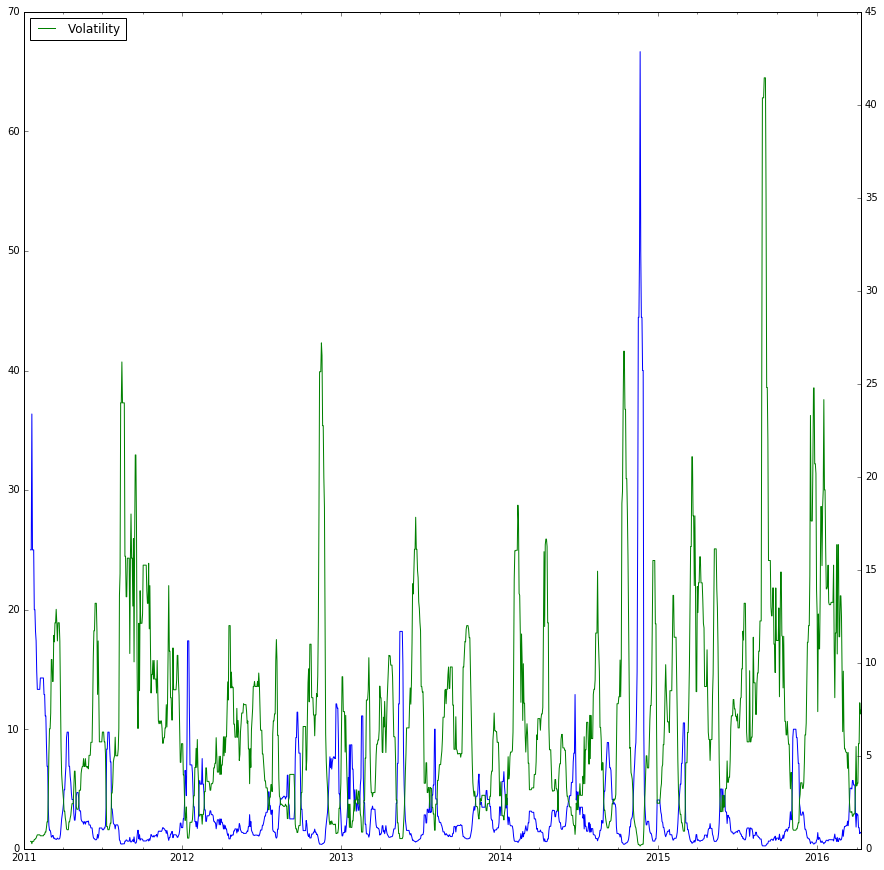

In [8]:

figsize(15,15)

volatility_metric.plot(c='b', label='PosSize')
vola.plot(secondary_y=True, c='g', label='Volatility')
legend(loc=2)

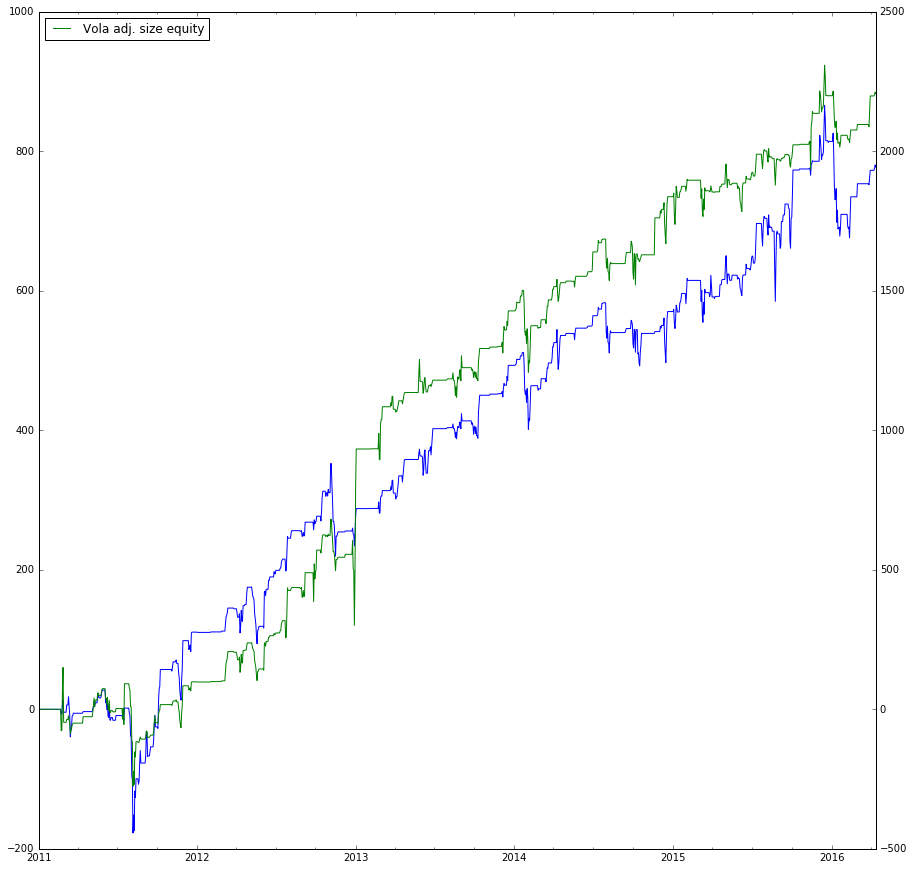

In [9]:
#X axis is initial equity curve
#Colored blue
x=equity
x.plot(label='Base equity')

#Y axis is equity curve with position management
#Colored green
y=pl * possize_vola_median
y.dropna().cumsum().plot(secondary_y=True, label='Vola adj. size equity')
legend(loc=2)

# Step 2: deposit risk based position sizing

In [10]:
# Initial deposit
init_deposit = 100000

# risk value in percents
risk_value = 3  # Percent

max DD -0.4249938375


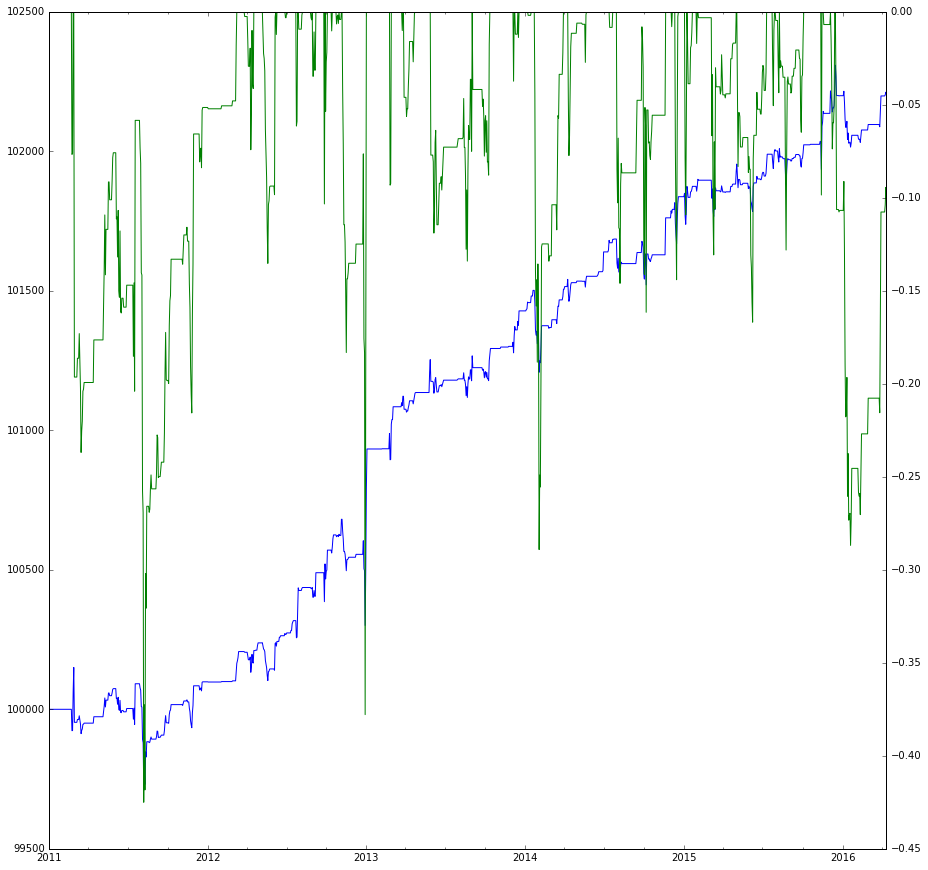

In [12]:
#
# 1. Set deposit size
#
first_index = pl.index[0]


# 2. Adjusting PnL to volatility
system_pnl = pl * possize_vola_median
pnl = system_pnl

_equity = pnl.cumsum() + init_deposit
#
# 3. Calculating absolute and relative Drawdown
#
dd = (_equity - _equity.expanding().max())
dd_percent = ((_equity - _equity.expanding().max()) / _equity.expanding().max()) * 100

_equity.plot()
dd_percent.plot(secondary_y=True)
#
# 4. Getting value of max DD in percents.
#
min_dd_percent = dd_percent.min() # !!! Looks into future, it is ok for raw exploration
#
# 5. Getting system weight multiplier. 
#
system_portfolio_weight = abs(risk_value / min_dd_percent)

print('max DD', dd_percent.min())

system weight 7.05892588384
max DD % -2.97302050293


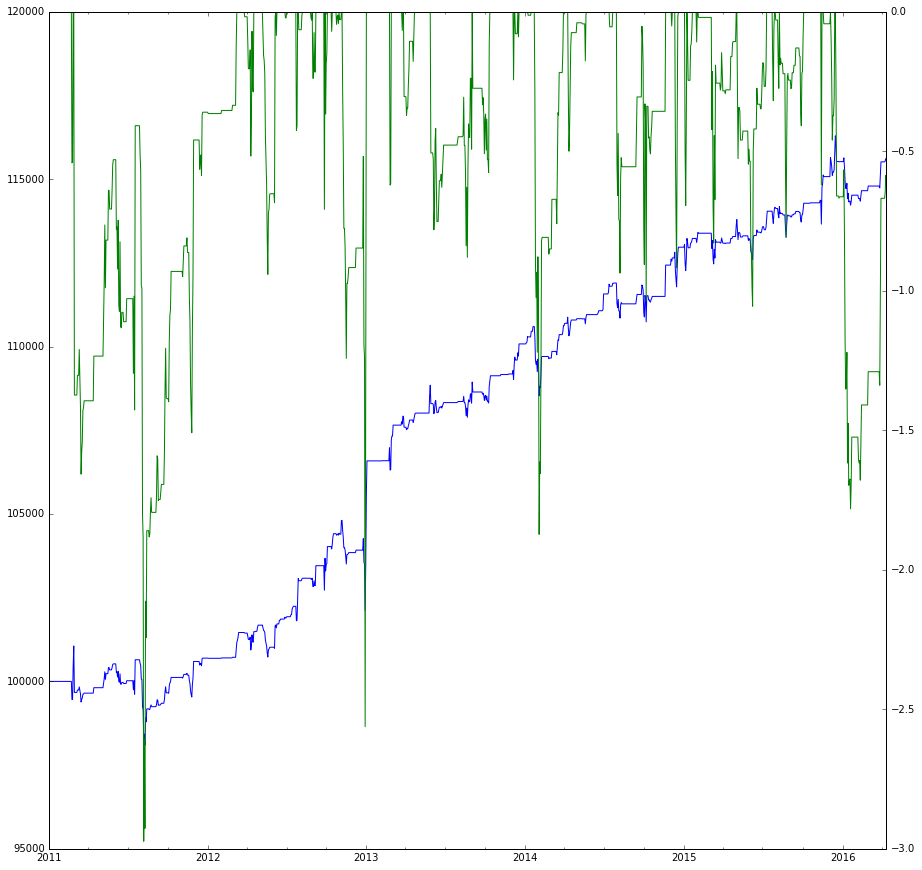

In [13]:
#
# 8. Multiply vola adjusted PnL on system weight. 
#    And after all we get adequate position size for this system which traded on 100k usd depo
#    But weight is fixed.
#
system_pnl = (pl*possize_vola_median) * system_portfolio_weight

pnl = system_pnl

_equity = pnl.cumsum() + init_deposit

dd = (_equity - _equity.expanding().max())
dd_percent = ((_equity - _equity.expanding().max()) / _equity.expanding().max()) * 100

_equity.plot()
dd_percent.plot(secondary_y=True)

print('system weight', system_portfolio_weight)
print('max DD %', dd_percent.min())